In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
# import tensorflow_probability.python as tfp
# import tensorflow_probability.python.layers as tfpl
import tensorflow_probability.python.distributions as tfd

In [3]:
archs = np.array([[-1,-1],
                  [2,-2],
                  [0,0]])

In [4]:
def generate_data (archs, n_points, noise=0.1):
    
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    Y0=np.linalg.norm(data-archs[0],axis=1)
    Y1=np.linalg.norm(data-archs[1],axis=1)
    Y2=np.linalg.norm(data-archs[2],axis=1)
    Y0=Y0/np.max(Y0)
    Y1=Y0/np.max(Y1)
    Y2=Y0/np.max(Y2)
    Y=np.concatenate((np.expand_dims(Y0,axis=1),np.expand_dims(Y1,axis=1),np.expand_dims(Y2,axis=1)),axis=1)
    
    return data, Y

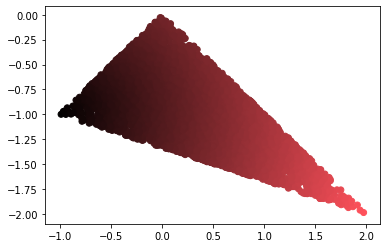

In [5]:
x_train, y_train = generate_data (archs,10000,noise=0.0)
x_test, y_test = generate_data (archs,1000,noise=0.0)

data0,data1 = x_train.T
plt.scatter(data0, data1, color=y_train)

In [6]:
def get_zfixed ( dim_latent_space ):
    
    z_fixed_t = np.zeros([dim_latent_space, dim_latent_space + 1])

    for k in range(0, dim_latent_space):
        s = 0.0
        for i in range(0, k):
            s = s + z_fixed_t[i, k] ** 2
  
        z_fixed_t[k, k] = np.sqrt(1.0 - s)

        for j in range(k + 1, dim_latent_space + 1):
            s = 0.0
            for i in range(0, k):
                s = s + z_fixed_t[i, k] * z_fixed_t[i, j]

            z_fixed_t[k, j] = (-1.0 / float(dim_latent_space) - s) / z_fixed_t[k, k]
            z_fixed = np.transpose(z_fixed_t)
                    
    return z_fixed


In [138]:
original_dim = x_train.shape [1]
sideinfo_dim = y_train.shape [1]

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
y_train = np.reshape(y_train, [-1, sideinfo_dim])
y_test = np.reshape(y_test, [-1, sideinfo_dim])


# network parameters
intermediate_dim = 32
batch_size = 256
latent_dim = 2
simplex_vrtxs = latent_dim + 1
epochs = 200


# encoder
input_x = tfk.Input(shape=(original_dim,), name='encoder_input_x')

x = tfkl.Dense(intermediate_dim, activation='relu')(input_x)
A = tfkl.Dense (simplex_vrtxs, activation=tf.nn.softmax)(x)
B_t = tfkl.Dense (simplex_vrtxs)(x)
B = tf.nn.softmax(tf.transpose(B_t), axis=1)

z_fixed = get_zfixed (latent_dim)
z_fixed = tf.constant (z_fixed, dtype='float32')
mu = tf.matmul(A, z_fixed)
z_pred = tf.matmul(B,mu)
sigma = tfkl.Dense(latent_dim)(x)
t = tfd.Normal(mu,sigma)

input_y = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y')
y = tf.identity(input_y)

encoder = tfk.Model([input_x,input_y], [t.sample(),mu,sigma,y], name='encoder')
encoder.summary()


# decoder
latent_inputs = tfk.Input(shape=(latent_dim,), name='z_sampling')
input_y_lat = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y_lat')

x = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
x_hat = tfkl.Dense(original_dim, activation='linear')(x)

y = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
y_hat = tfkl.Dense(sideinfo_dim, activation='linear')(y) 

decoder = tfk.Model([latent_inputs,input_y_lat], [x_hat,y_hat], name='decoder')
decoder.summary()


# # VAE
encoded = encoder([input_x,input_y])
outputs = decoder( [encoded[0],encoded[-1]])
vae = tfk.Model([input_x,input_y], outputs, name='vae')


reconstruction_loss = tfk.losses.mse (input_x, outputs[0])
class_loss = tfk.losses.mse ( input_y, outputs[1])
archetype_loss = tf.reduce_sum( tfk.losses.mse(z_fixed, z_pred))

kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
beta = 1

vae_loss = tf.reduce_mean(reconstruction_loss + class_loss + beta*kl_loss + archetype_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


vae.fit([x_train,y_train],  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,y_test],None))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_203 (Dense)               (None, 32)           96          encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_204 (Dense)               (None, 3)            99          dense_203[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_MatMul_60 (TensorFl [(None, 2)]          0           dense_204[0][0]                  
____________________________________________________________________________________________

10000/10000 [==============================] - 1s 131us/sample - loss: 2.3015 - val_loss: 2.0233
Epoch 2/200
10000/10000 [==============================] - 0s 37us/sample - loss: 1.9010 - val_loss: 1.7835
Epoch 3/200
10000/10000 [==============================] - 0s 32us/sample - loss: 1.7205 - val_loss: 1.6575
Epoch 4/200
10000/10000 [==============================] - 0s 35us/sample - loss: 1.6044 - val_loss: 1.5375
Epoch 5/200
10000/10000 [==============================] - 0s 37us/sample - loss: 1.4542 - val_loss: 1.3572
Epoch 6/200
10000/10000 [==============================] - 0s 30us/sample - loss: 1.2484 - val_loss: 1.1454
Epoch 7/200
10000/10000 [==============================] - 0s 29us/sample - loss: 1.0667 - val_loss: 1.0083
Epoch 8/200
10000/10000 [==============================] - 0s 28us/sample - loss: 0.9693 - val_loss: 0.9316
Epoch 9/200
10000/10000 [==============================] - 0s 30us/sample - loss: 0.8911 - val_loss: 0.8350
Epoch 10/200
10000/10000 [=============

10000/10000 [==============================] - 0s 36us/sample - loss: 0.2153 - val_loss: 0.2059
Epoch 77/200
10000/10000 [==============================] - 0s 33us/sample - loss: 0.2128 - val_loss: 0.2027
Epoch 78/200
10000/10000 [==============================] - 0s 28us/sample - loss: 0.2106 - val_loss: 0.1997
Epoch 79/200
10000/10000 [==============================] - 0s 35us/sample - loss: 0.2098 - val_loss: 0.1966
Epoch 80/200
10000/10000 [==============================] - 0s 31us/sample - loss: 0.2015 - val_loss: 0.1932
Epoch 81/200
10000/10000 [==============================] - 0s 32us/sample - loss: 0.1987 - val_loss: 0.1907
Epoch 82/200
10000/10000 [==============================] - 0s 30us/sample - loss: 0.1960 - val_loss: 0.1884
Epoch 83/200
10000/10000 [==============================] - 0s 31us/sample - loss: 0.1921 - val_loss: 0.1850
Epoch 84/200
10000/10000 [==============================] - 0s 28us/sample - loss: 0.1908 - val_loss: 0.1824
Epoch 85/200
10000/10000 [======

Epoch 151/200
10000/10000 [==============================] - 0s 32us/sample - loss: 0.1239 - val_loss: 0.1158
Epoch 152/200
10000/10000 [==============================] - 0s 35us/sample - loss: 0.1253 - val_loss: 0.1151
Epoch 153/200
10000/10000 [==============================] - 0s 28us/sample - loss: 0.1259 - val_loss: 0.1152
Epoch 154/200
10000/10000 [==============================] - 0s 30us/sample - loss: 0.1245 - val_loss: 0.1155
Epoch 155/200
10000/10000 [==============================] - 0s 30us/sample - loss: 0.1249 - val_loss: 0.1130
Epoch 156/200
10000/10000 [==============================] - 0s 32us/sample - loss: 0.1231 - val_loss: 0.1130
Epoch 157/200
10000/10000 [==============================] - 0s 27us/sample - loss: 0.1216 - val_loss: 0.1138
Epoch 158/200
10000/10000 [==============================] - 0s 30us/sample - loss: 0.1193 - val_loss: 0.1120
Epoch 159/200
10000/10000 [==============================] - 0s 31us/sample - loss: 0.1199 - val_loss: 0.1117
Epoch 160/

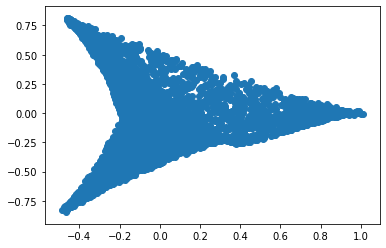

In [139]:
x_pred = encoder.predict([x_train,y_train])
dataX,dataY = x_pred[0].T
plt.scatter(dataX,dataY)


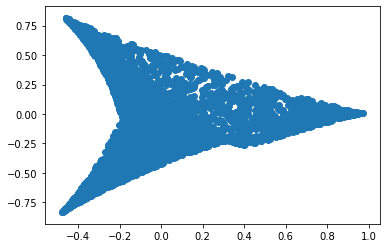

In [140]:
x_pred = encoder.predict([x_train,y_train])
dataX,dataY = x_pred[1].T
plt.scatter(dataX,dataY)


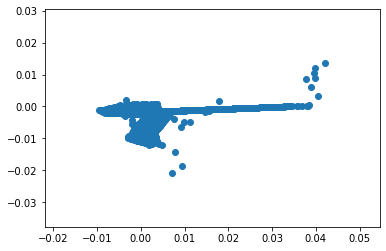

In [141]:
x_pred = encoder.predict([x_train,y_train])
dataX,dataY = x_pred[2].T
plt.scatter(dataX,dataY)


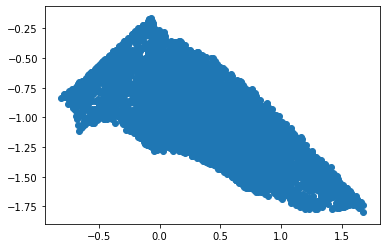

In [142]:
x_pred = vae.predict([x_train,y_train])
dataX,dataY = x_pred[0].T
plt.scatter(dataX,dataY)


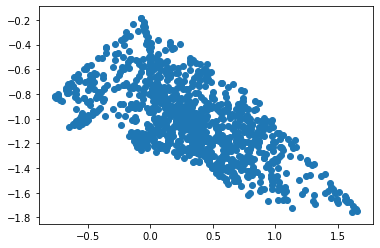

In [143]:
x_pred = vae.predict([x_test,y_test])
dataX,dataY = x_pred[0].T
plt.scatter(dataX,dataY)
